In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/d2 with d1.zip'

Archive:  /content/drive/MyDrive/d2 with d1.zip
   creating: d2 with d1/
   creating: d2 with d1/Testing/
   creating: d2 with d1/Testing/glioma_tumor/
  inflating: d2 with d1/Testing/glioma_tumor/image(1).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(10).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(100).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(11).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(12).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(13).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(14).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(15).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(16).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(17).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(18).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(19).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(2).jpg  
  inflating: d2 with d1/Testing/glioma_tumor/image(20).j

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from tqdm import tqdm
from warnings import filterwarnings
import pickle
import os
import shutil
import random
import cv2

# Import sklearn modules
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score

# Import tf modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG19

filterwarnings("ignore")
np.random.seed(0)


In [ ]:
train_img = []
train_labels_not_encoded = []

test_img = []
test_labels_not_encoded = []

path_train = '/content/d2 with d1/Training/'  # Update the path to the Training directory in session storage
path_test = '/content/d2 with d1/Testing/'  # Update the path to the Testing directory in session storage

img_size = 180
for i in os.listdir(path_train):
    for j in tqdm(os.listdir(path_train + i)):
        train_img.append(cv2.resize(cv2.imread(path_train + i + '/' + j), (img_size, img_size)))
        train_labels_not_encoded.append(i)

for i in os.listdir(path_test):
    for j in tqdm(os.listdir(path_test + i)):
        test_img.append(cv2.resize(cv2.imread(path_test + i + '/' + j), (img_size, img_size)))
        test_labels_not_encoded.append(i)

train_img = np.array(train_img)
test_img = np.array(test_img)

100%|██████████| 150/150 [00:00<00:00, 592.68it/s]


In [ ]:
y_train = pd.get_dummies(train_labels_not_encoded)
y_test = pd.get_dummies(test_labels_not_encoded)
labels=y_train.columns

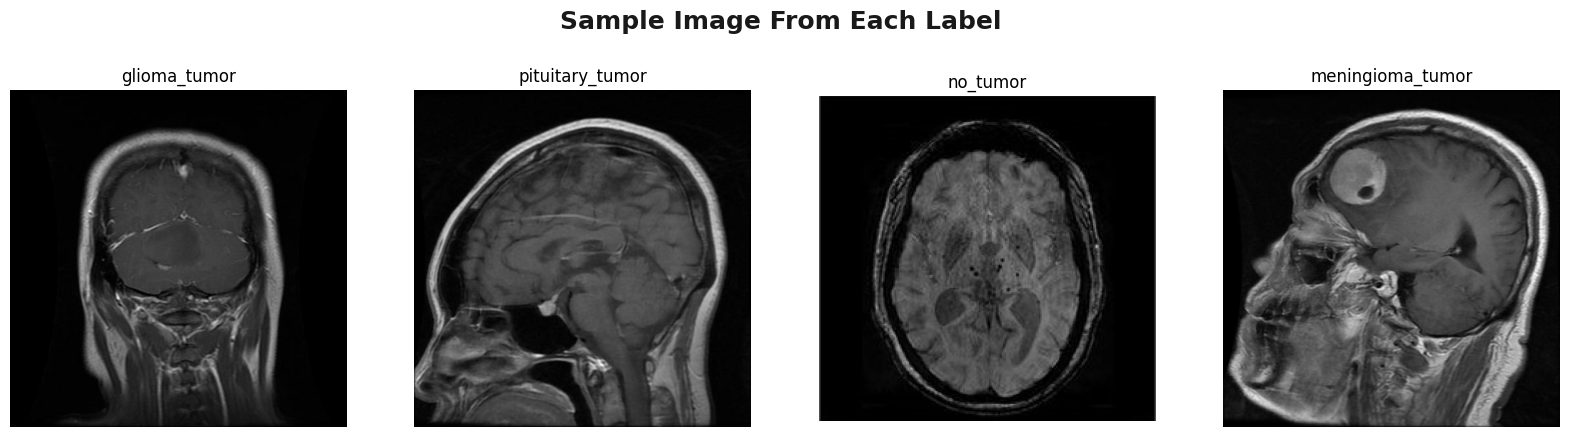

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
         color="black",y=0.61,x=0.4,alpha=0.9)
for count, ele in enumerate(os.listdir(path_train)):
    for j in os.listdir(path_train+ele):
        img= cv2.imread(path_train+ele+'/'+j)
        ax[count].imshow(img)
        ax[count].set_title(ele)
        ax[count].axis('off')
        break

In [ ]:
print("Train size:", train_img.shape[0], "Test size:", test_img.shape[0])

Train size: 3526 Test size: 599


In [ ]:
y_train

,glioma_tumor,meningioma_tumor,no_tumor,pituitary_tumor
0,True,False,False,False
1,True,False,False,False
2,True,False,False,False
3,True,False,False,False
4,True,False,False,False
...,...,...,...,...
3521,False,True,False,False
3522,False,True,False,False
3523,False,True,False,False
3524,False,True,False,False


In [ ]:
def clear_previous_calculations():
    try:
        shutil.rmtree("logs")
    except Exception as e:
        pass

    for i in ["tumor_model.h5", "predictions.pkl"]:
        try:
            os.remove(i)
        except Exception as e:
            pass

In [ ]:
def get_model():
    data_augmentation = Sequential([
        layers.RandomFlip("horizontal_and_vertical", input_shape=(img_size, img_size, 3)),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.1)
    ])
    vgg19 = VGG19(include_top=False, input_shape=(img_size, img_size, 3))
    model = Sequential([
        data_augmentation,
        vgg19,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])
    return model

In [ ]:
def get_callbacks():
    tensorboard = TensorBoard(log_dir = 'logs', histogram_freq=1)
    checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2,
                                  mode='auto',verbose=1, min_lr=0.000001)
    return [tensorboard,checkpoint,reduce_lr]

In [ ]:
def get_fig_and_axes_list(plot_count,column_number=2):
    """
    This function takes in the number of subplots to be plotted and the desired number of columns for the subplot grid.
    It then calculates the number of rows required and generates a matplotlib figure with the given number of subplots
    in a grid with the desired number of columns.

    Args:
    - plot_count: int, the number of subplots to be plotted
    - column_number: int, the number of columns in the subplot grid. Default value is 2.

    Returns:
    - fig: matplotlib Figure object, the generated figure
    - axes_list: list of matplotlib Axes objects, the axes of the subplots in the figure
    """
    reminder_num = plot_count % column_number
    row_num = (plot_count // column_number) + (reminder_num > 0)
    axes_list = []
    row_number_alignment = np.ones((row_num, column_number), dtype="int")
    if reminder_num != 0:
        row_number_alignment[-1,-(column_number - reminder_num):] = 0
    coefficient = (3.5 if plot_count==1 else 5.2)
    col_size = coefficient*column_number
    row_size = coefficient*row_num
    fig = plt.figure(figsize=(col_size, row_size), layout="constrained")
    spec = fig.add_gridspec(row_num, column_number)
    for i in range(row_number_alignment.shape[0]):
        for j in range(row_number_alignment.shape[1]):
            if row_number_alignment[i,j] == 1:
                ax = fig.add_subplot(spec[i,j])
                axes_list.append(ax)
    return fig,axes_list

In [ ]:
def get_axes_list(length, column_number=2):
    fig, axes_list = get_fig_and_axes_list(length, column_number=column_number )
    return axes_list

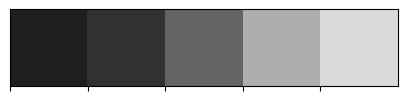

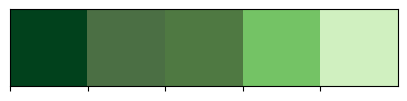

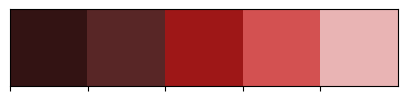

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #Supress warnings
clear_previous_calculations()
model = get_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                       

In [ ]:
epochs = 10
batch_size=32
all_callbacks = get_callbacks()
history = model.fit(train_img, y_train, validation_split=0.1,  epochs=epochs, batch_size=batch_size,
                    callbacks=all_callbacks,  shuffle=True, verbose=1, workers=1)
model.load_weights('effnet.h5')

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 1.9277 - accuracy: 0.3382
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to effnet.h5
100/100 [==============================] - 69s 452ms/step - loss: 1.9277 - accuracy: 0.3382 - val_loss: 1.5902 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 1.2191 - accuracy: 0.4403
Epoch 2: val_accuracy improved from 0.00000 to 0.07932, saving model to effnet.h5
100/100 [==============================] - 39s 394ms/step - loss: 1.2191 - accuracy: 0.4403 - val_loss: 1.5561 - val_accuracy: 0.0793 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 1.2430 - accuracy: 0.4277
Epoch 3: val_accuracy improved from 0.07932 to 0.09348, saving model to effnet.h5
100/100 [==============================] - 39s 393ms/step - loss: 1.2430 - accuracy: 0.4277 - val_loss: 1.4984 - val_accuracy: 0.0935 - lr: 0.0010
Epoch 4/10
100/100 [====

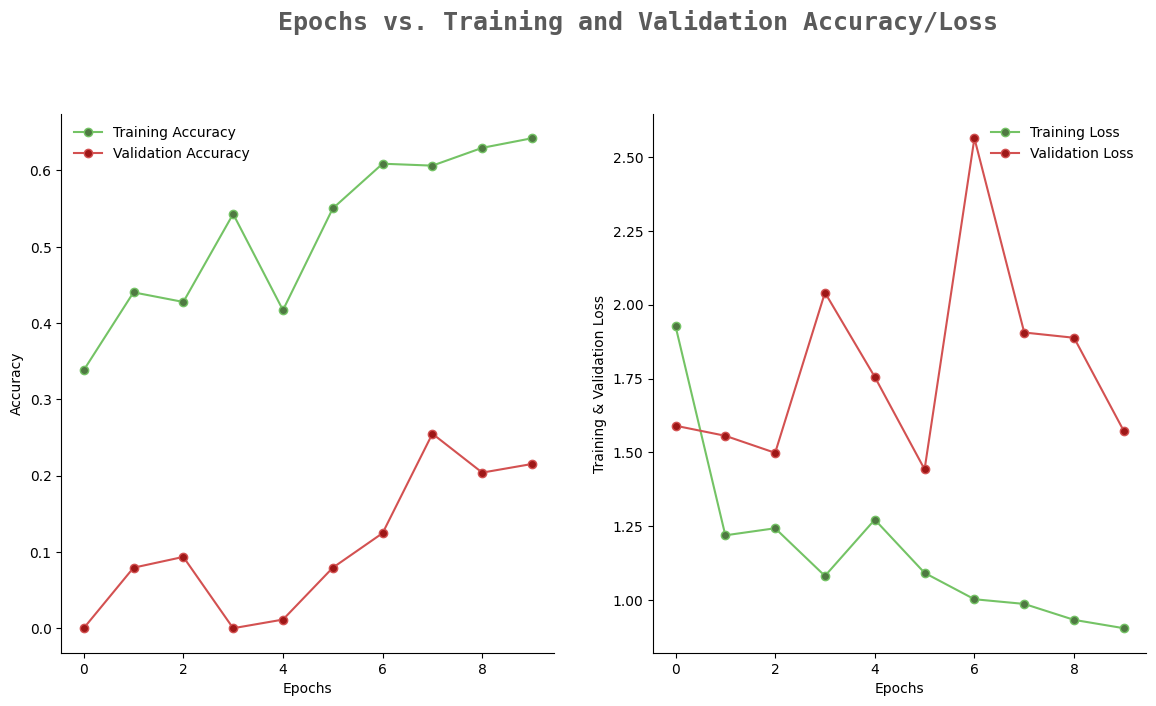

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_count = [i for i in range(len(train_acc))]

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)

sns.despine()
ax[0].plot(epochs_count, train_acc, marker='o',markerfacecolor=colors_green[2], color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs_count, val_acc, marker='o',markerfacecolor=colors_red[2], color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs_count, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Loss')
ax[1].plot(epochs_count, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred_prob = model.predict(test_img)
pred = np.argmax(pred_prob,axis=1)
y_test_encoded = np.argmax(y_test.to_numpy(),axis=1)
y_train_encoded = np.argmax(y_train.to_numpy(),axis=1)
train_pred_proba = model.predict(train_img)
train_pred = np.argmax(train_pred_proba,axis=1)

111/111 [==============================] - 13s 114ms/step


In [ ]:
boosting_model = GradientBoostingClassifier()
boosting_model.fit(train_pred_proba,  y_train_encoded)
meta_test = boosting_model.predict(pred_prob)


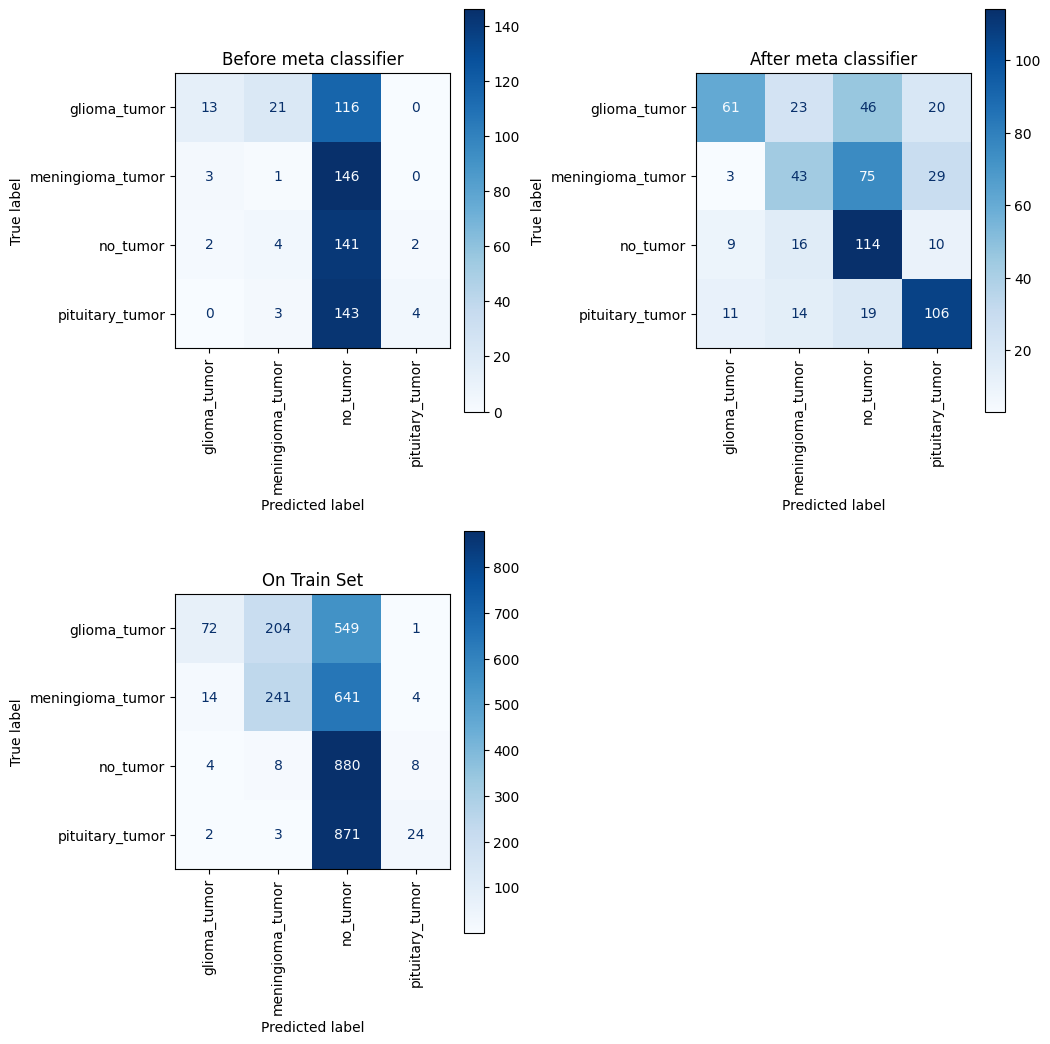

In [ ]:
axes = get_axes_list(3)

axes[0].set_title("Before meta classifier")
ConfusionMatrixDisplay.from_predictions(y_test_encoded, pred, display_labels=labels,
                                        cmap='Blues', ax=axes[0], xticks_rotation="vertical")

axes[1].set_title("After meta classifier")
ConfusionMatrixDisplay.from_predictions(y_test_encoded, meta_test, display_labels=labels,
                                        cmap='Blues', ax=axes[1], xticks_rotation="vertical")

axes[2].set_title("On Train Set")
ConfusionMatrixDisplay.from_predictions(y_train_encoded, train_pred, display_labels=labels,
                                        cmap='Blues', ax=axes[2], xticks_rotation="vertical")

In [ ]:
before = roc_auc_score(y_test, pred_prob,multi_class="ovo")
print("Before meta classifier:\n", classification_report(y_test_encoded,pred),"\n RUC-AUC:", before)

Before meta classifier:
               precision    recall  f1-score   support

           0       0.72      0.09      0.15       150
           1       0.03      0.01      0.01       150
           2       0.26      0.95      0.41       149
           3       0.67      0.03      0.05       150

    accuracy                           0.27       599
   macro avg       0.42      0.27      0.16       599
weighted avg       0.42      0.27      0.16       599
 
 RUC-AUC: 0.5929089998654729


In [ ]:
after = roc_auc_score(y_test, boosting_model.predict_proba(pred_prob),multi_class="ovo")
print("After meta classifier:\n", classification_report(y_test_encoded, meta_test),"\n RUC-AUC:", after)

After meta classifier:
               precision    recall  f1-score   support

           0       0.73      0.41      0.52       150
           1       0.45      0.29      0.35       150
           2       0.45      0.77      0.57       149
           3       0.64      0.71      0.67       150

    accuracy                           0.54       599
   macro avg       0.57      0.54      0.53       599
weighted avg       0.57      0.54      0.53       599
 
 RUC-AUC: 0.7714394403671097


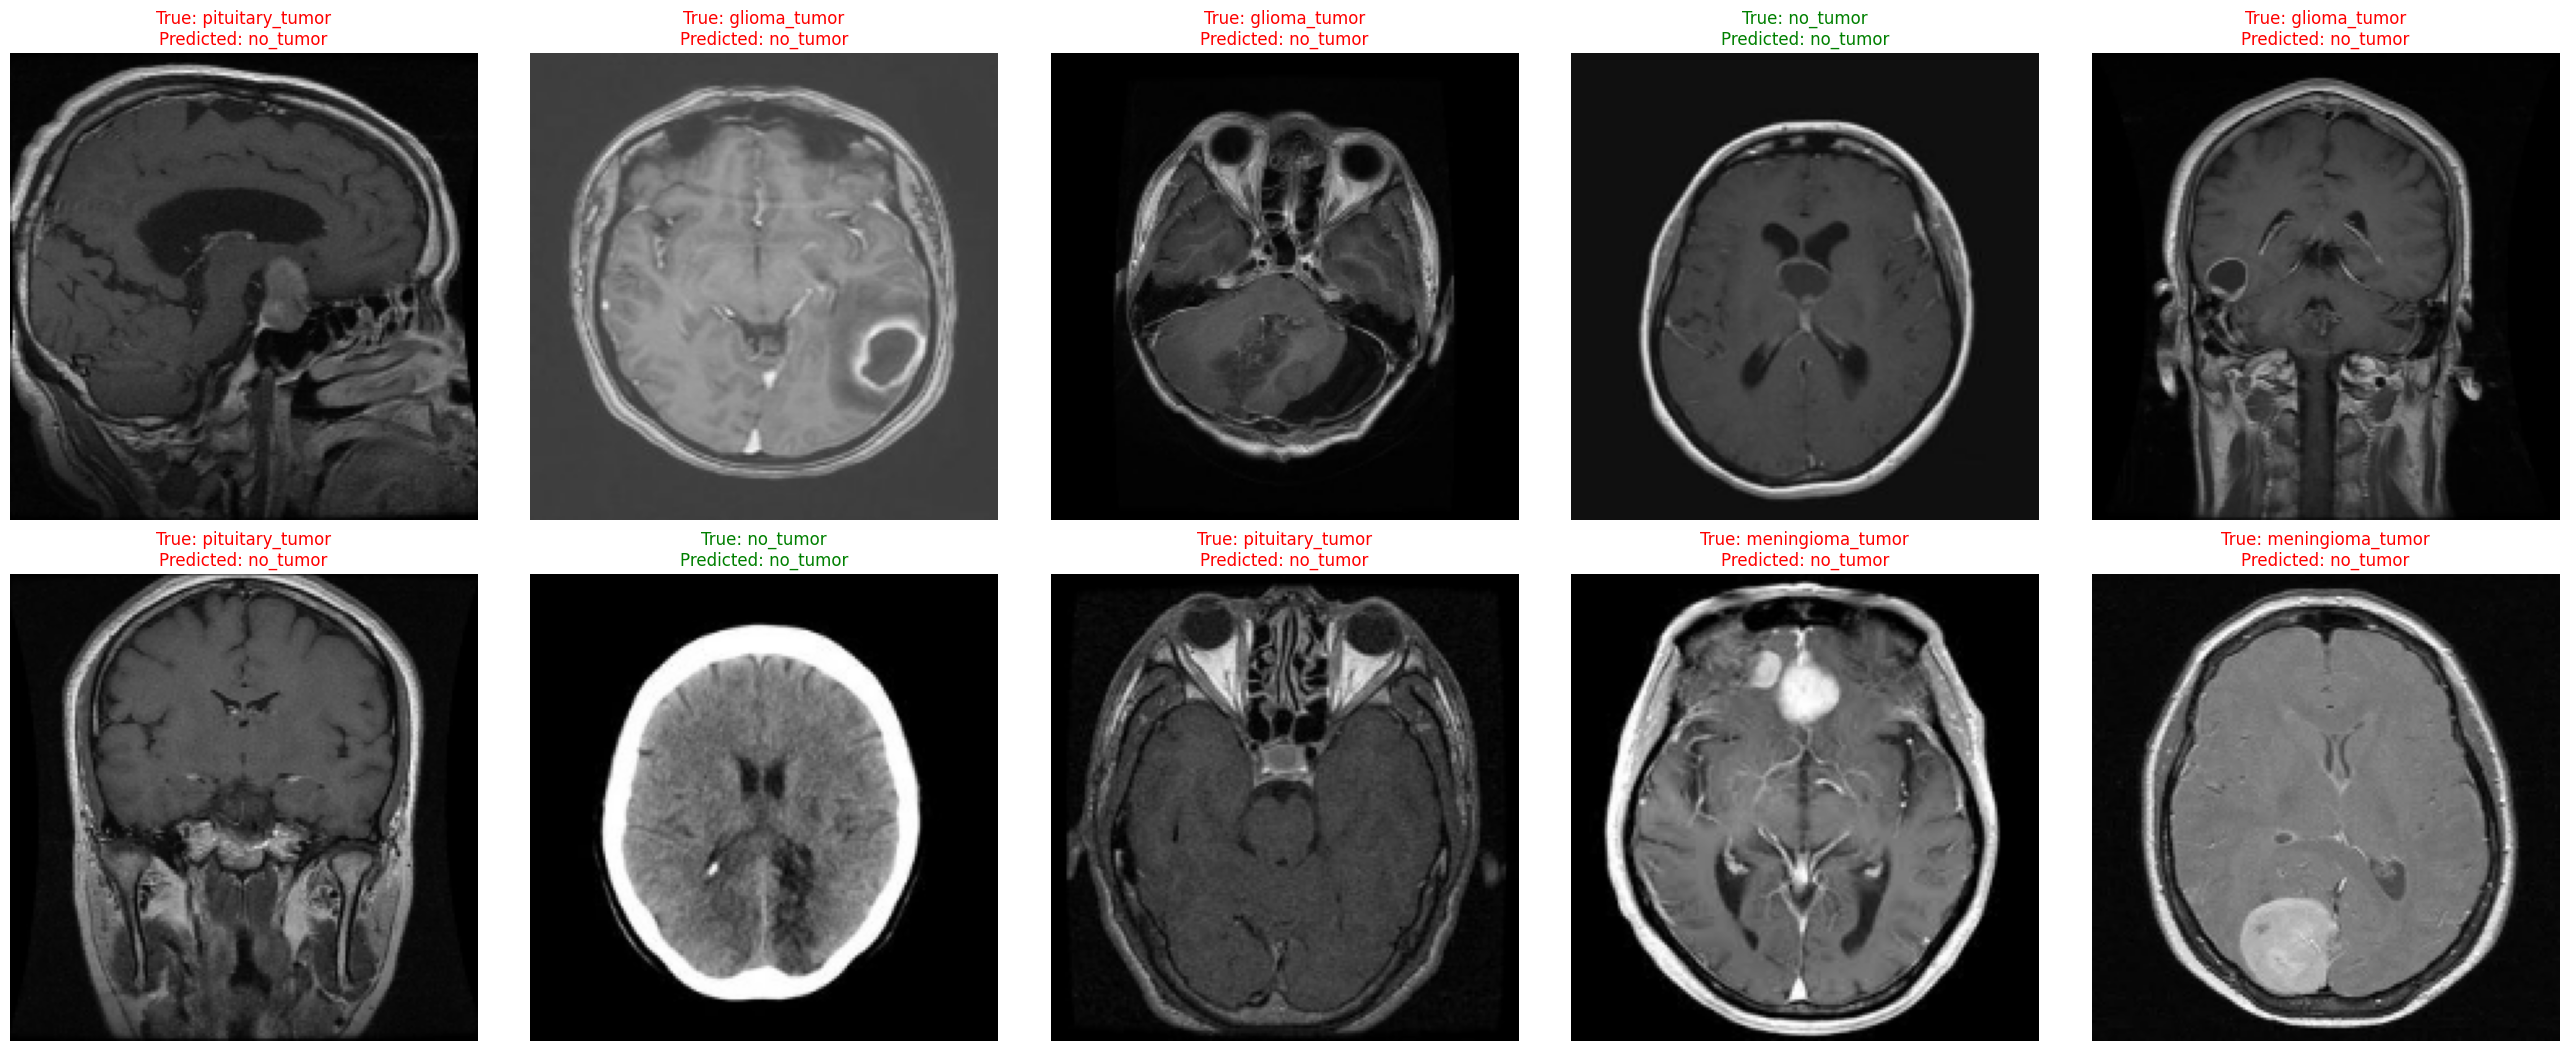

In [ ]:
fig,ax_list = get_fig_and_axes_list(10,5)
random_image_index = np.random.randint(test_img.shape[0], size=10)
for count, ele in enumerate(random_image_index):
    ax_list[count]
    ax_list[count].imshow(test_img[ele])
    color = ("green" if pred[ele] == y_test_encoded[ele] else "red")
    ax_list[count].set_title(f"True: {test_labels_not_encoded[ele]}\nPredicted: { labels[pred[ele]] }", color=color)
    ax_list[count].axis('off')